In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt

# Load datasets
train_path = r"R:\AIniverse\PROJECTS\mainstream\maltrafdect\UNSW_NB15_training-set.csv"
test_path = r"R:\AIniverse\PROJECTS\mainstream\maltrafdect\UNSW_NB15_testing-set.csv"
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# Show dataset shapes
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

# Feature engineering: Add packet rate
train_df['packet_rate'] = train_df['spkts'] / (train_df['dur'] + 1e-6)  # Avoid division by zero
test_df['packet_rate'] = test_df['spkts'] / (test_df['dur'] + 1e-6)

# One-hot encode categorical features
categorical_features = ['proto', 'service', 'state']
train_df = pd.get_dummies(train_df, columns=categorical_features, dtype=float)
test_df = pd.get_dummies(test_df, columns=categorical_features, dtype=float)
train_df, test_df = train_df.align(test_df, join='outer', axis=1, fill_value=0)

# Encode target
le = LabelEncoder()
all_values = pd.concat([train_df['attack_cat'], test_df['attack_cat']], axis=0).astype(str)
le.fit(all_values)
train_df['attack_cat'] = le.transform(train_df['attack_cat'].astype(str))
test_df['attack_cat'] = le.transform(test_df['attack_cat'].astype(str))

# Scale features
num_cols = train_df.drop(columns=['id', 'label', 'attack_cat']).columns
scaler = StandardScaler()
train_df[num_cols] = scaler.fit_transform(train_df[num_cols])
test_df[num_cols] = scaler.transform(test_df[num_cols])

# Split features & labels
X_train = train_df.drop(columns=['id', 'label', 'attack_cat']).to_numpy()
y_train = train_df['attack_cat'].to_numpy()
X_test = test_df.drop(columns=['id', 'label', 'attack_cat']).to_numpy()
y_test = test_df['attack_cat'].to_numpy()

# Validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42, stratify=y_train
)

print("Train:", X_train.shape, " Val:", X_val.shape, " Test:", X_test.shape)

# Hybrid SMOTE + undersampling
over = SMOTE(sampling_strategy={0: 5000, 1: 5000, 9: 5000}, k_neighbors=1, random_state=42)
under = RandomUnderSampler(sampling_strategy={5: 10000, 6: 10000}, random_state=42)
pipeline = Pipeline([('over', over), ('under', under)])
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

print("After SMOTE + undersampling, Train shape:", X_train_resampled.shape)

# Feature selection
base_model = xgb.XGBClassifier(
    n_estimators=50,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    objective='multi:softmax',
    eval_metric='mlogloss',
    num_class=len(np.unique(y_train))
)
base_model.fit(X_train_resampled, y_train_resampled)
selector = SelectFromModel(base_model, threshold='2*mean', prefit=True)
X_train_resampled = selector.transform(X_train_resampled)
X_val = selector.transform(X_val)
X_test = selector.transform(X_test)

print("After feature selection, Train shape:", X_train_resampled.shape)

# Compute class weights
class_counts = np.bincount(y_train_resampled)
class_weights = max(class_counts) / class_counts
class_weights = np.where(np.isinf(class_weights), 1.0, class_weights)

Train shape: (82332, 45)
Test shape: (175341, 45)
Train: (74098, 197)  Val: (8234, 197)  Test: (175341, 197)
After SMOTE + undersampling, Train shape: (57641, 197)
After feature selection, Train shape: (57641, 19)


In [24]:
class_counts = np.bincount(y_train_resampled)
class_weights = max(class_counts) / class_counts
class_weights = np.where(np.isinf(class_weights), 1.0, class_weights)

# Define parameters
params = {
    'objective': 'multi:softmax',
    'num_class': len(np.unique(y_train)),
    'max_depth': 5,
    'eta': 0.1,
    'min_child_weight': 3,
    'eval_metric': ['mlogloss', 'merror'],
    'seed': 42,
    'scale_pos_weight': class_weights
}

# Cross-validation for hyperparameter tuning
dtrain = xgb.DMatrix(X_train_resampled, label=y_train_resampled)
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=1000,
    nfold=3,
    metrics=['mlogloss'],
    early_stopping_rounds=10,
    seed=42,
    verbose_eval=True
)
print("Best number of rounds:", cv_results.shape[0])

# Train final model
dtrain = xgb.DMatrix(X_train_resampled, label=y_train_resampled)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)
evals = [(dtrain, 'train'), (dval, 'val')]
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=cv_results.shape[0],
    evals=evals,
    early_stopping_rounds=10,
    verbose_eval=True
)
y_pred = bst.predict(dtest)


[0]	train-mlogloss:2.01807+0.00122	test-mlogloss:2.01915+0.00130
[1]	train-mlogloss:1.82737+0.00056	test-mlogloss:1.82929+0.00100
[2]	train-mlogloss:1.68110+0.00059	test-mlogloss:1.68382+0.00104
[3]	train-mlogloss:1.56291+0.00125	test-mlogloss:1.56621+0.00152


R:\AIniverse\.venv\Lib\site-packages\xgboost\training.py:209: UserWarning: [02:05:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
R:\AIniverse\.venv\Lib\site-packages\xgboost\training.py:215: UserWarning: [02:05:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


[4]	train-mlogloss:1.46341+0.00168	test-mlogloss:1.46737+0.00171
[5]	train-mlogloss:1.37868+0.00159	test-mlogloss:1.38322+0.00150
[6]	train-mlogloss:1.30573+0.00163	test-mlogloss:1.31090+0.00130
[7]	train-mlogloss:1.24150+0.00196	test-mlogloss:1.24722+0.00146
[8]	train-mlogloss:1.18479+0.00164	test-mlogloss:1.19102+0.00122
[9]	train-mlogloss:1.13490+0.00167	test-mlogloss:1.14166+0.00116
[10]	train-mlogloss:1.09027+0.00156	test-mlogloss:1.09747+0.00105
[11]	train-mlogloss:1.05006+0.00144	test-mlogloss:1.05773+0.00076
[12]	train-mlogloss:1.01353+0.00153	test-mlogloss:1.02157+0.00073
[13]	train-mlogloss:0.98039+0.00123	test-mlogloss:0.98865+0.00041
[14]	train-mlogloss:0.95057+0.00094	test-mlogloss:0.95922+0.00015
[15]	train-mlogloss:0.92290+0.00103	test-mlogloss:0.93193+0.00024
[16]	train-mlogloss:0.89805+0.00085	test-mlogloss:0.90740+0.00017
[17]	train-mlogloss:0.87499+0.00084	test-mlogloss:0.88464+0.00014
[18]	train-mlogloss:0.85371+0.00062	test-mlogloss:0.86370+0.00047
[19]	train-mlogl

R:\AIniverse\.venv\Lib\site-packages\xgboost\callback.py:386: UserWarning: [02:05:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  self.starting_round = model.num_boosted_rounds()


[9]	train-mlogloss:1.13652	train-merror:0.25118	val-mlogloss:1.00518	val-merror:0.18205
[10]	train-mlogloss:1.09242	train-merror:0.24994	val-mlogloss:0.95721	val-merror:0.18411
[11]	train-mlogloss:1.05200	train-merror:0.24866	val-mlogloss:0.91425	val-merror:0.18229
[12]	train-mlogloss:1.01625	train-merror:0.24859	val-mlogloss:0.87549	val-merror:0.17865
[13]	train-mlogloss:0.98316	train-merror:0.24833	val-mlogloss:0.84057	val-merror:0.17926
[14]	train-mlogloss:0.95330	train-merror:0.24758	val-mlogloss:0.80899	val-merror:0.17816
[15]	train-mlogloss:0.92561	train-merror:0.24694	val-mlogloss:0.77987	val-merror:0.17683
[16]	train-mlogloss:0.89985	train-merror:0.24467	val-mlogloss:0.75256	val-merror:0.17525
[17]	train-mlogloss:0.87724	train-merror:0.24410	val-mlogloss:0.72892	val-merror:0.17549
[18]	train-mlogloss:0.85593	train-merror:0.24398	val-mlogloss:0.70653	val-merror:0.17501
[19]	train-mlogloss:0.83692	train-merror:0.24302	val-mlogloss:0.68709	val-merror:0.17416
[20]	train-mlogloss:0.

In [25]:
# Predictions on validation and test sets
y_val_pred = bst.predict(dval)
y_test_pred = bst.predict(dtest)

# Validation classification report
print("\nValidation Classification Report:\n")
print(classification_report(y_val, y_val_pred, target_names=le.classes_))

# Test classification report
print("\nTest Classification Report:\n")
print(classification_report(y_test, y_test_pred, target_names=le.classes_))
print("\nTest Confusion Matrix:\n")
print(confusion_matrix(y_test, y_test_pred))


Validation Classification Report:

                precision    recall  f1-score   support

      Analysis       0.01      0.01      0.01        68
      Backdoor       0.11      0.47      0.17        58
           DoS       0.45      0.58      0.51       409
      Exploits       0.75      0.69      0.72      1113
       Fuzzers       0.75      0.70      0.72       606
       Generic       1.00      0.97      0.98      1887
        Normal       0.98      0.96      0.97      3700
Reconnaissance       0.93      0.77      0.84       350
     Shellcode       0.48      0.53      0.50        38
         Worms       0.31      1.00      0.48         5

      accuracy                           0.86      8234
     macro avg       0.58      0.67      0.59      8234
  weighted avg       0.89      0.86      0.87      8234


Test Classification Report:

                precision    recall  f1-score   support

      Analysis       0.05      0.03      0.04      2000
      Backdoor       0.11      0.1

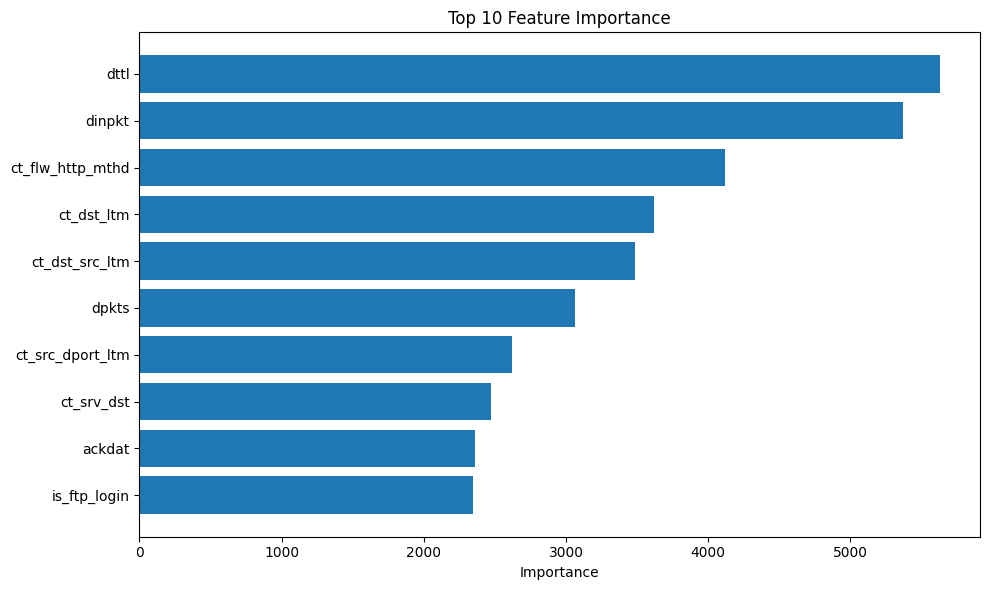

In [22]:

# Feature importance plot
feature_scores = bst.get_score(importance_type='weight')  # or 'gain'
# Map scores to feature names
feature_importance = np.array([feature_scores.get(f'f{i}', 0) for i in range(X_train_resampled.shape[1])])
feature_names = train_df.drop(columns=['id', 'label', 'attack_cat']).columns
sorted_idx = np.argsort(feature_importance)[-10:]  # Top 10 features

plt.figure(figsize=(10, 6))
plt.barh(feature_names[sorted_idx], feature_importance[sorted_idx])
plt.title("Top 10 Feature Importance")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTEENN
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
train_path = r"R:\AIniverse\PROJECTS\mainstream\maltrafdect\UNSW_NB15_training-set.csv"
test_path = r"R:\AIniverse\PROJECTS\mainstream\maltrafdect\UNSW_NB15_testing-set.csv"
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# Show dataset shapes
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

# Feature engineering
train_df['packet_rate'] = train_df['spkts'] / (train_df['dur'] + 1e-6)
test_df['packet_rate'] = test_df['spkts'] / (test_df['dur'] + 1e-6)
train_df['byte_rate'] = train_df['sbytes'] / (train_df['dur'] + 1e-6)
test_df['byte_rate'] = test_df['sbytes'] / (test_df['dur'] + 1e-6)
train_df['state_ttl_ratio'] = train_df['ct_state_ttl'] / (train_df['sttl'] + 1e-6)
test_df['state_ttl_ratio'] = test_df['ct_state_ttl'] / (test_df['sttl'] + 1e-6)

# One-hot encode categorical features
categorical_features = ['proto', 'service', 'state']
train_df = pd.get_dummies(train_df, columns=categorical_features, dtype=float)
test_df = pd.get_dummies(test_df, columns=categorical_features, dtype=float)
train_df, test_df = train_df.align(test_df, join='outer', axis=1, fill_value=0)

# Remove highly correlated features
corr_matrix = train_df.drop(columns=['id', 'label', 'attack_cat']).corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
train_df = train_df.drop(columns=to_drop)
test_df = test_df.drop(columns=to_drop)

# Encode target
le = LabelEncoder()
all_values = pd.concat([train_df['attack_cat'], test_df['attack_cat']], axis=0).astype(str)
le.fit(all_values)
train_df['attack_cat'] = le.transform(train_df['attack_cat'].astype(str))
test_df['attack_cat'] = le.transform(test_df['attack_cat'].astype(str))

# Scale features
num_cols = train_df.drop(columns=['id', 'label', 'attack_cat']).columns
scaler = StandardScaler()
train_df[num_cols] = scaler.fit_transform(train_df[num_cols])
test_df[num_cols] = scaler.transform(test_df[num_cols])

# Split features & labels
X_train = train_df.drop(columns=['id', 'label', 'attack_cat']).to_numpy()
y_train = train_df['attack_cat'].to_numpy()
X_test = test_df.drop(columns=['id', 'label', 'attack_cat']).to_numpy()
y_test = test_df['attack_cat'].to_numpy()

# Validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42, stratify=y_train
)

print("Train:", X_train.shape, " Val:", X_val.shape, " Test:", X_test.shape)

# SMOTEENN for balanced sampling
smote_enn = SMOTEENN(sampling_strategy='not majority', random_state=42, smote=SMOTE(k_neighbors=1, random_state=42))
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

print("After SMOTEENN, Train shape:", X_train_resampled.shape)

# Feature selection
base_model = xgb.XGBClassifier(
    n_estimators=50,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    objective='multi:softmax',
    eval_metric='mlogloss',
    num_class=len(np.unique(y_train))
)
base_model.fit(X_train_resampled, y_train_resampled)
selector = SelectFromModel(base_model, threshold='2*mean', prefit=True)
X_train_resampled = selector.transform(X_train_resampled)
X_val = selector.transform(X_val)
X_test = selector.transform(X_test)

print("After feature selection, Train shape:", X_train_resampled.shape)

# Compute class weights
class_counts = np.bincount(y_train_resampled)
class_weights = max(class_counts) / class_counts
class_weights = np.where(np.isinf(class_weights), 1.0, class_weights)

# Define parameters
params = {
    'objective': 'multi:softmax',
    'num_class': len(np.unique(y_train)),
    'max_depth': 5,
    'eta': 0.05,
    'min_child_weight': 5,
    'gamma': 0.1,
    'subsample': 0.8,
    'eval_metric': ['mlogloss', 'merror'],
    'seed': 42,
    'scale_pos_weight': class_weights
}

# Cross-validation
dtrain = xgb.DMatrix(X_train_resampled, label=y_train_resampled)
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=1000,
    nfold=5,
    metrics=['mlogloss'],
    early_stopping_rounds=10,
    seed=42,
    verbose_eval=True
)
print("Best number of rounds:", cv_results.shape[0])

# Train final model
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)
evals = [(dtrain, 'train'), (dval, 'val')]
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=cv_results.shape[0],
    evals=evals,
    early_stopping_rounds=10,
    verbose_eval=True
)

Train shape: (82332, 45)
Test shape: (175341, 45)
Train: (74098, 179)  Val: (8234, 179)  Test: (175341, 179)
After SMOTEENN, Train shape: (227639, 179)
After feature selection, Train shape: (227639, 16)


R:\AIniverse\.venv\Lib\site-packages\xgboost\training.py:209: UserWarning: [02:10:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
R:\AIniverse\.venv\Lib\site-packages\xgboost\training.py:215: UserWarning: [02:10:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)


[0]	train-mlogloss:2.13229+0.00030	test-mlogloss:2.13241+0.00036
[1]	train-mlogloss:1.99567+0.00031	test-mlogloss:1.99587+0.00043
[2]	train-mlogloss:1.88126+0.00043	test-mlogloss:1.88156+0.00061
[3]	train-mlogloss:1.78253+0.00063	test-mlogloss:1.78288+0.00094
[4]	train-mlogloss:1.69608+0.00084	test-mlogloss:1.69649+0.00125
[5]	train-mlogloss:1.61911+0.00112	test-mlogloss:1.61961+0.00151
[6]	train-mlogloss:1.54981+0.00090	test-mlogloss:1.55042+0.00173
[7]	train-mlogloss:1.48706+0.00108	test-mlogloss:1.48770+0.00206
[8]	train-mlogloss:1.42976+0.00108	test-mlogloss:1.43044+0.00217
[9]	train-mlogloss:1.37750+0.00116	test-mlogloss:1.37825+0.00219
[10]	train-mlogloss:1.32923+0.00133	test-mlogloss:1.33005+0.00217
[11]	train-mlogloss:1.28436+0.00126	test-mlogloss:1.28523+0.00246
[12]	train-mlogloss:1.24215+0.00130	test-mlogloss:1.24309+0.00270
[13]	train-mlogloss:1.20289+0.00118	test-mlogloss:1.20386+0.00273
[14]	train-mlogloss:1.16632+0.00102	test-mlogloss:1.16732+0.00276
[15]	train-mlogloss:

R:\AIniverse\.venv\Lib\site-packages\xgboost\callback.py:386: UserWarning: [02:14:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  self.starting_round = model.num_boosted_rounds()


[1]	train-mlogloss:1.99592	train-merror:0.16420	val-mlogloss:2.04120	val-merror:0.34685
[2]	train-mlogloss:1.88114	train-merror:0.16426	val-mlogloss:1.94645	val-merror:0.34758
[3]	train-mlogloss:1.78253	train-merror:0.16140	val-mlogloss:1.86586	val-merror:0.34588
[4]	train-mlogloss:1.69596	train-merror:0.16017	val-mlogloss:1.79580	val-merror:0.34503
[5]	train-mlogloss:1.61833	train-merror:0.15967	val-mlogloss:1.73360	val-merror:0.34528
[6]	train-mlogloss:1.54911	train-merror:0.15989	val-mlogloss:1.67887	val-merror:0.34503
[7]	train-mlogloss:1.48668	train-merror:0.16073	val-mlogloss:1.62984	val-merror:0.34467
[8]	train-mlogloss:1.42938	train-merror:0.16006	val-mlogloss:1.58590	val-merror:0.34382
[9]	train-mlogloss:1.37736	train-merror:0.15633	val-mlogloss:1.54558	val-merror:0.34103
[10]	train-mlogloss:1.32922	train-merror:0.15585	val-mlogloss:1.50852	val-merror:0.34090
[11]	train-mlogloss:1.28445	train-merror:0.15483	val-mlogloss:1.47419	val-merror:0.34115
[12]	train-mlogloss:1.24190	tr

In [27]:

# Predict
y_val_pred = bst.predict(dval).astype(int)
y_test_pred = bst.predict(dtest).astype(int)

# Evaluate on validation set
print("\nValidation Classification Report:\n")
print(classification_report(y_val, y_val_pred, target_names=le.classes_))

# Evaluate on test set
print("\nTest Classification Report:\n")
print(classification_report(y_test, y_test_pred, target_names=le.classes_))
print("\nTest Confusion Matrix:\n")
print(confusion_matrix(y_test, y_test_pred))

# ROC-AUC (one-vs-rest)
y_test_proba = bst.predict(dtest, output_margin=True)
y_test_proba = np.exp(y_test_proba) / np.sum(np.exp(y_test_proba), axis=1, keepdims=True)
roc_auc = roc_auc_score(y_test, y_test_proba, multi_class='ovr')
print("\nTest ROC-AUC (OvR):", roc_auc)


Validation Classification Report:

                precision    recall  f1-score   support

      Analysis       0.11      0.60      0.19        68
      Backdoor       0.13      0.16      0.14        58
           DoS       0.35      0.50      0.41       409
      Exploits       0.82      0.54      0.65      1113
       Fuzzers       0.30      0.56      0.39       606
       Generic       1.00      0.96      0.98      1887
        Normal       0.97      0.71      0.82      3700
Reconnaissance       0.84      0.84      0.84       350
     Shellcode       0.08      0.87      0.14        38
         Worms       0.16      1.00      0.27         5

      accuracy                           0.73      8234
     macro avg       0.48      0.67      0.48      8234
  weighted avg       0.85      0.73      0.77      8234


Test Classification Report:

                precision    recall  f1-score   support

      Analysis       0.05      0.29      0.09      2000
      Backdoor       0.13      0.1

In [ ]:

# Feature importance plot
feature_importance = bst.get_score(importance_type='gain')
feature_names = train_df.drop(columns=['id', 'label', 'attack_cat']).columns[selector.get_support()]
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)[:10]
sorted_names = [f[0] for f in sorted_features]
sorted_scores = [f[1] for f in sorted_features]
plt.figure(figsize=(10, 6))
plt.barh(sorted_names, sorted_scores, color='skyblue', edgecolor='black')
plt.title("Top 10 Feature Importance (Gain)")
plt.xlabel("Importance (Gain)")
plt.tight_layout()
plt.show()
